## 导入模块

In [1]:
import os

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.distributions.uniform import Uniform
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter

## 数据加载类

In [2]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir='/home/public/anime-faces', transform=None):
        self.root_dir = root_dir
        self.images = []
        self.get_images()
        self.transform = transform
        
    def get_images(self):
        for category in os.listdir(self.root_dir):
            if os.path.isdir(os.path.join(self.root_dir, category)):
                self.images.extend(map(lambda x: '{}/{}'.format(category, x), 
                                       os.listdir(os.path.join(self.root_dir, category))))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(os.path.join(self.root_dir, image_path))
        if self.transform:
            image = self.transform(image)
        return image
    
    def show_image(self, index):
        plt.imshow(self[index].permute(1, 2, 0))
        

## 可视化初始化

In [3]:
writer = SummaryWriter('./runs')

## 模型(DCGAN)
### Use ReLU activation in generator for all layers except for the output, which uses Tanh.
### Use LeakyReLU activation in the discriminator for all layers.

In [4]:
class Generator(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()
        self.gen = nn.Sequential(
            self.deconv(in_channels=in_channels, out_channels=1024, padding=0),
            self.deconv(in_channels=1024, out_channels=512, stride=2),
            self.deconv(in_channels=512, out_channels=256, stride=2),
            self.deconv(in_channels=256, out_channels=128, stride=2),
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.init_weight()
        
    def forward(self, x):
        return self.gen(x)
        
    def deconv(self, in_channels, out_channels, kernel_size=4, stride=1, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
                
    def init_weight(self, w_mean=0., w_std=0.02, b_mean=1, b_std=0.02):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, mean=w_mean, std=w_std)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=b_mean, std=b_std)
                nn.init.constant_(m.bias, 0)
        
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.dis = nn.Sequential(
            self.conv(in_channels=3, out_channels=128, stride=2),
            self.conv(in_channels=128, out_channels=256, stride=2),
            self.conv(in_channels=256, out_channels=512, stride=2),
            self.conv(in_channels=512, out_channels=1024, stride=2),
            nn.Conv2d(in_channels=1024, out_channels=1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )
    
        self.init_weight()
        
    def forward(self, x):
        return self.dis(x)
    
    def conv(self, in_channels, out_channels, kernel_size=4, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def init_weight(self, w_mean=0., w_std=0.02, b_mean=1, b_std=0.02):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=w_mean, std=w_std)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, mean=b_mean, std=b_std)
                nn.init.constant_(m.bias, 0)
            
gen = Generator(in_channels=100)
dis = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
dis.to(device)

writer.add_graph(gen, input_to_model=torch.rand([1, 100, 1, 1]).cuda())

## 参数设置

In [5]:
ngpu = 2
IS_PARALLEL = True if ngpu > 1 else False
nz = 100
num_epochs = 20
batch_size = 64
fixed_noise = torch.randn(32, nz, 1, 1, device=device)

real_idx = 1
fake_idx = 0

if IS_PARALLEL and torch.cuda.device_count() > 1:
    gen = nn.DataParallel(gen)
    dis = nn.DataParallel(dis)
    
criterion = nn.BCELoss()

beta1 = 0.5
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(beta1, 0.999))

lr_scheduler_g = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=3, gamma=0.1)
lr_scheduler_d = torch.optim.lr_scheduler.StepLR(dis_optimizer, step_size=3, gamma=0.1)  # 每set_size个epoch更新一次学习率

## 数据处理

In [6]:
t = transforms.Compose(
    [
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = AnimeDataset(root_dir='/home/public/anime-faces', transform=t)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## 训练

[0/20][0/1799]	Loss_D: 1.6824	Loss_G: 3.8692
[0/20][10/1799]	Loss_D: 1.6168	Loss_G: 27.1872
[0/20][20/1799]	Loss_D: 4.6758	Loss_G: 53.2080
[0/20][30/1799]	Loss_D: 4.0005	Loss_G: 52.1974
[0/20][40/1799]	Loss_D: 3.2806	Loss_G: 51.4151
[0/20][50/1799]	Loss_D: 3.0758	Loss_G: 50.3667
[0/20][60/1799]	Loss_D: 2.8902	Loss_G: 48.2330
[0/20][70/1799]	Loss_D: 2.6727	Loss_G: 48.1632
[0/20][80/1799]	Loss_D: 2.6938	Loss_G: 47.0303
[0/20][90/1799]	Loss_D: 2.6928	Loss_G: 46.8028
[0/20][100/1799]	Loss_D: 2.8305	Loss_G: 46.1625
[0/20][110/1799]	Loss_D: 2.7693	Loss_G: 46.2607
[0/20][120/1799]	Loss_D: 2.4349	Loss_G: 46.0115
[0/20][130/1799]	Loss_D: 2.8391	Loss_G: 45.3719
[0/20][140/1799]	Loss_D: 2.6910	Loss_G: 45.6480
[0/20][150/1799]	Loss_D: 2.7176	Loss_G: 45.2481
[0/20][160/1799]	Loss_D: 2.6153	Loss_G: 44.2341
[0/20][170/1799]	Loss_D: 2.4707	Loss_G: 44.4076
[0/20][180/1799]	Loss_D: 2.1031	Loss_G: 44.1403
[0/20][190/1799]	Loss_D: 2.5862	Loss_G: 43.8743
[0/20][200/1799]	Loss_D: 2.2617	Loss_G: 43.2807
[0/2

[0/20][1720/1799]	Loss_D: 1.1400	Loss_G: 2.6406
[0/20][1730/1799]	Loss_D: 1.1729	Loss_G: 2.6710
[0/20][1740/1799]	Loss_D: 0.9998	Loss_G: 1.8576
[0/20][1750/1799]	Loss_D: 1.0275	Loss_G: 1.8141
[0/20][1760/1799]	Loss_D: 1.5482	Loss_G: 3.6563
[0/20][1770/1799]	Loss_D: 0.8473	Loss_G: 2.4442
[0/20][1780/1799]	Loss_D: 1.1686	Loss_G: 3.9706
[0/20][1790/1799]	Loss_D: 1.4232	Loss_G: 2.0796
[1/20][0/1799]	Loss_D: 1.5062	Loss_G: 2.0727
[1/20][10/1799]	Loss_D: 1.2431	Loss_G: 4.0837
[1/20][20/1799]	Loss_D: 1.1258	Loss_G: 2.5955
[1/20][30/1799]	Loss_D: 1.0505	Loss_G: 2.5613
[1/20][40/1799]	Loss_D: 0.8904	Loss_G: 3.4800
[1/20][50/1799]	Loss_D: 1.2100	Loss_G: 3.1188
[1/20][60/1799]	Loss_D: 1.1858	Loss_G: 3.3768
[1/20][70/1799]	Loss_D: 0.9123	Loss_G: 2.9639
[1/20][80/1799]	Loss_D: 0.8743	Loss_G: 1.7613
[1/20][90/1799]	Loss_D: 0.8356	Loss_G: 3.3003
[1/20][100/1799]	Loss_D: 0.6604	Loss_G: 2.2421
[1/20][110/1799]	Loss_D: 1.2039	Loss_G: 2.2587
[1/20][120/1799]	Loss_D: 1.2645	Loss_G: 1.8868
[1/20][130/1799]

[1/20][1650/1799]	Loss_D: 0.7153	Loss_G: 3.7912
[1/20][1660/1799]	Loss_D: 0.9025	Loss_G: 2.6166
[1/20][1670/1799]	Loss_D: 1.3744	Loss_G: 6.4383
[1/20][1680/1799]	Loss_D: 0.6887	Loss_G: 2.3106
[1/20][1690/1799]	Loss_D: 0.9356	Loss_G: 2.0771
[1/20][1700/1799]	Loss_D: 0.8746	Loss_G: 3.7585
[1/20][1710/1799]	Loss_D: 0.8098	Loss_G: 4.8546
[1/20][1720/1799]	Loss_D: 0.8740	Loss_G: 2.7233
[1/20][1730/1799]	Loss_D: 0.7573	Loss_G: 2.9442
[1/20][1740/1799]	Loss_D: 0.6924	Loss_G: 2.8312
[1/20][1750/1799]	Loss_D: 0.7138	Loss_G: 3.4494
[1/20][1760/1799]	Loss_D: 1.1141	Loss_G: 1.7801
[1/20][1770/1799]	Loss_D: 1.2000	Loss_G: 1.5324
[1/20][1780/1799]	Loss_D: 0.6103	Loss_G: 2.8997
[1/20][1790/1799]	Loss_D: 0.7209	Loss_G: 3.0042
[2/20][0/1799]	Loss_D: 2.3158	Loss_G: 6.3835
[2/20][10/1799]	Loss_D: 0.9132	Loss_G: 2.2630
[2/20][20/1799]	Loss_D: 0.7779	Loss_G: 2.8744
[2/20][30/1799]	Loss_D: 0.6847	Loss_G: 3.3010
[2/20][40/1799]	Loss_D: 0.7277	Loss_G: 3.0302
[2/20][50/1799]	Loss_D: 0.9308	Loss_G: 2.4124
[2/20

[2/20][1580/1799]	Loss_D: 0.7837	Loss_G: 2.8650
[2/20][1590/1799]	Loss_D: 1.2150	Loss_G: 3.7105
[2/20][1600/1799]	Loss_D: 0.9836	Loss_G: 4.3432
[2/20][1610/1799]	Loss_D: 0.8323	Loss_G: 2.5101
[2/20][1620/1799]	Loss_D: 0.7345	Loss_G: 2.3381
[2/20][1630/1799]	Loss_D: 0.6421	Loss_G: 2.7362
[2/20][1640/1799]	Loss_D: 1.1940	Loss_G: 2.0063
[2/20][1650/1799]	Loss_D: 0.7770	Loss_G: 2.2215
[2/20][1660/1799]	Loss_D: 0.5617	Loss_G: 2.8367
[2/20][1670/1799]	Loss_D: 0.7173	Loss_G: 3.6251
[2/20][1680/1799]	Loss_D: 0.7967	Loss_G: 4.0385
[2/20][1690/1799]	Loss_D: 0.7691	Loss_G: 1.9915
[2/20][1700/1799]	Loss_D: 0.6276	Loss_G: 2.6568
[2/20][1710/1799]	Loss_D: 0.7347	Loss_G: 2.4205
[2/20][1720/1799]	Loss_D: 0.5734	Loss_G: 4.2262
[2/20][1730/1799]	Loss_D: 1.2186	Loss_G: 1.4676
[2/20][1740/1799]	Loss_D: 0.7458	Loss_G: 2.2713
[2/20][1750/1799]	Loss_D: 1.4263	Loss_G: 0.8997
[2/20][1760/1799]	Loss_D: 1.1484	Loss_G: 1.4286
[2/20][1770/1799]	Loss_D: 1.0257	Loss_G: 0.8402
[2/20][1780/1799]	Loss_D: 1.1006	Loss_G:

[3/20][1510/1799]	Loss_D: 0.4680	Loss_G: 2.6343
[3/20][1520/1799]	Loss_D: 0.5179	Loss_G: 2.3973
[3/20][1530/1799]	Loss_D: 0.5074	Loss_G: 2.2951
[3/20][1540/1799]	Loss_D: 0.5216	Loss_G: 2.3837
[3/20][1550/1799]	Loss_D: 0.4881	Loss_G: 2.5495
[3/20][1560/1799]	Loss_D: 0.4654	Loss_G: 2.4397
[3/20][1570/1799]	Loss_D: 0.5187	Loss_G: 2.6952
[3/20][1580/1799]	Loss_D: 0.5461	Loss_G: 2.4070
[3/20][1590/1799]	Loss_D: 0.5273	Loss_G: 2.3517
[3/20][1600/1799]	Loss_D: 0.5126	Loss_G: 2.4432
[3/20][1610/1799]	Loss_D: 0.5295	Loss_G: 2.3494
[3/20][1620/1799]	Loss_D: 0.5202	Loss_G: 2.4906
[3/20][1630/1799]	Loss_D: 0.4786	Loss_G: 2.7712
[3/20][1640/1799]	Loss_D: 0.4921	Loss_G: 2.6668
[3/20][1650/1799]	Loss_D: 0.5057	Loss_G: 2.8232
[3/20][1660/1799]	Loss_D: 0.4987	Loss_G: 2.6036
[3/20][1670/1799]	Loss_D: 0.5163	Loss_G: 2.7711
[3/20][1680/1799]	Loss_D: 0.5162	Loss_G: 2.5196
[3/20][1690/1799]	Loss_D: 0.5284	Loss_G: 2.6441
[3/20][1700/1799]	Loss_D: 0.4697	Loss_G: 2.3479
[3/20][1710/1799]	Loss_D: 0.4760	Loss_G:

[4/20][1440/1799]	Loss_D: 0.4616	Loss_G: 2.7733
[4/20][1450/1799]	Loss_D: 0.5134	Loss_G: 2.4060
[4/20][1460/1799]	Loss_D: 0.5036	Loss_G: 2.7300
[4/20][1470/1799]	Loss_D: 0.5340	Loss_G: 2.2017
[4/20][1480/1799]	Loss_D: 0.4714	Loss_G: 2.6889
[4/20][1490/1799]	Loss_D: 0.4521	Loss_G: 2.8916
[4/20][1500/1799]	Loss_D: 0.4782	Loss_G: 2.7366
[4/20][1510/1799]	Loss_D: 0.4990	Loss_G: 2.7077
[4/20][1520/1799]	Loss_D: 0.4836	Loss_G: 2.8896
[4/20][1530/1799]	Loss_D: 0.4549	Loss_G: 2.9548
[4/20][1540/1799]	Loss_D: 0.4623	Loss_G: 3.0649
[4/20][1550/1799]	Loss_D: 0.4608	Loss_G: 2.7655
[4/20][1560/1799]	Loss_D: 0.4893	Loss_G: 2.5656
[4/20][1570/1799]	Loss_D: 0.5507	Loss_G: 2.5223
[4/20][1580/1799]	Loss_D: 0.4907	Loss_G: 2.3712
[4/20][1590/1799]	Loss_D: 0.4448	Loss_G: 3.0873
[4/20][1600/1799]	Loss_D: 0.4890	Loss_G: 3.0198
[4/20][1610/1799]	Loss_D: 0.4928	Loss_G: 2.4466
[4/20][1620/1799]	Loss_D: 0.4567	Loss_G: 2.9536
[4/20][1630/1799]	Loss_D: 0.4248	Loss_G: 3.0352
[4/20][1640/1799]	Loss_D: 0.4410	Loss_G:

[5/20][1370/1799]	Loss_D: 0.4264	Loss_G: 2.8701
[5/20][1380/1799]	Loss_D: 0.4584	Loss_G: 3.4640
[5/20][1390/1799]	Loss_D: 0.5082	Loss_G: 2.7601
[5/20][1400/1799]	Loss_D: 0.4613	Loss_G: 2.5181
[5/20][1410/1799]	Loss_D: 0.5248	Loss_G: 2.5780
[5/20][1420/1799]	Loss_D: 0.5371	Loss_G: 2.1706
[5/20][1430/1799]	Loss_D: 0.4527	Loss_G: 3.1185
[5/20][1440/1799]	Loss_D: 0.4730	Loss_G: 2.9712
[5/20][1450/1799]	Loss_D: 0.4463	Loss_G: 2.8889
[5/20][1460/1799]	Loss_D: 0.5274	Loss_G: 2.6130
[5/20][1470/1799]	Loss_D: 0.4954	Loss_G: 2.7012
[5/20][1480/1799]	Loss_D: 0.4445	Loss_G: 2.7136
[5/20][1490/1799]	Loss_D: 0.4662	Loss_G: 2.7287
[5/20][1500/1799]	Loss_D: 0.4852	Loss_G: 2.7001
[5/20][1510/1799]	Loss_D: 0.4884	Loss_G: 2.8079
[5/20][1520/1799]	Loss_D: 0.4707	Loss_G: 2.7382
[5/20][1530/1799]	Loss_D: 0.5158	Loss_G: 2.4226
[5/20][1540/1799]	Loss_D: 0.4366	Loss_G: 2.8345
[5/20][1550/1799]	Loss_D: 0.4593	Loss_G: 2.9762
[5/20][1560/1799]	Loss_D: 0.4341	Loss_G: 3.2082
[5/20][1570/1799]	Loss_D: 0.4994	Loss_G:

[6/20][1300/1799]	Loss_D: 0.4744	Loss_G: 2.9266
[6/20][1310/1799]	Loss_D: 0.4616	Loss_G: 2.7088
[6/20][1320/1799]	Loss_D: 0.4446	Loss_G: 2.5539
[6/20][1330/1799]	Loss_D: 0.4374	Loss_G: 2.9158
[6/20][1340/1799]	Loss_D: 0.4401	Loss_G: 2.9571
[6/20][1350/1799]	Loss_D: 0.4683	Loss_G: 2.9043
[6/20][1360/1799]	Loss_D: 0.4546	Loss_G: 2.7388
[6/20][1370/1799]	Loss_D: 0.4951	Loss_G: 2.4912
[6/20][1380/1799]	Loss_D: 0.4446	Loss_G: 2.8702
[6/20][1390/1799]	Loss_D: 0.4864	Loss_G: 2.8527
[6/20][1400/1799]	Loss_D: 0.4390	Loss_G: 2.9238
[6/20][1410/1799]	Loss_D: 0.4489	Loss_G: 2.7463
[6/20][1420/1799]	Loss_D: 0.4718	Loss_G: 2.8389
[6/20][1430/1799]	Loss_D: 0.4783	Loss_G: 2.6500
[6/20][1440/1799]	Loss_D: 0.4447	Loss_G: 2.6895
[6/20][1450/1799]	Loss_D: 0.4592	Loss_G: 2.6524
[6/20][1460/1799]	Loss_D: 0.4413	Loss_G: 2.7997
[6/20][1470/1799]	Loss_D: 0.4238	Loss_G: 3.0022
[6/20][1480/1799]	Loss_D: 0.4208	Loss_G: 3.1571
[6/20][1490/1799]	Loss_D: 0.4687	Loss_G: 2.8192
[6/20][1500/1799]	Loss_D: 0.4394	Loss_G:

[7/20][1230/1799]	Loss_D: 0.5557	Loss_G: 3.0235
[7/20][1240/1799]	Loss_D: 0.4292	Loss_G: 2.7137
[7/20][1250/1799]	Loss_D: 0.4390	Loss_G: 2.6523
[7/20][1260/1799]	Loss_D: 0.4169	Loss_G: 2.8841
[7/20][1270/1799]	Loss_D: 0.4445	Loss_G: 2.8393
[7/20][1280/1799]	Loss_D: 0.4433	Loss_G: 2.7244
[7/20][1290/1799]	Loss_D: 0.4495	Loss_G: 2.6350
[7/20][1300/1799]	Loss_D: 0.4583	Loss_G: 2.9121
[7/20][1310/1799]	Loss_D: 0.4294	Loss_G: 2.9620
[7/20][1320/1799]	Loss_D: 0.4407	Loss_G: 2.9260
[7/20][1330/1799]	Loss_D: 0.4396	Loss_G: 3.1274
[7/20][1340/1799]	Loss_D: 0.4068	Loss_G: 2.8804
[7/20][1350/1799]	Loss_D: 0.4513	Loss_G: 2.8263
[7/20][1360/1799]	Loss_D: 0.4373	Loss_G: 2.9187
[7/20][1370/1799]	Loss_D: 0.4388	Loss_G: 2.7204
[7/20][1380/1799]	Loss_D: 0.4864	Loss_G: 2.7864
[7/20][1390/1799]	Loss_D: 0.4597	Loss_G: 2.7063
[7/20][1400/1799]	Loss_D: 0.4418	Loss_G: 2.6134
[7/20][1410/1799]	Loss_D: 0.4338	Loss_G: 2.5506
[7/20][1420/1799]	Loss_D: 0.4429	Loss_G: 2.9547
[7/20][1430/1799]	Loss_D: 0.4226	Loss_G:

[8/20][1160/1799]	Loss_D: 0.4768	Loss_G: 2.9129
[8/20][1170/1799]	Loss_D: 0.4691	Loss_G: 2.7787
[8/20][1180/1799]	Loss_D: 0.4333	Loss_G: 3.0325
[8/20][1190/1799]	Loss_D: 0.4358	Loss_G: 3.1363
[8/20][1200/1799]	Loss_D: 0.4640	Loss_G: 2.6158
[8/20][1210/1799]	Loss_D: 0.4242	Loss_G: 3.2765
[8/20][1220/1799]	Loss_D: 0.4348	Loss_G: 2.6791
[8/20][1230/1799]	Loss_D: 0.4841	Loss_G: 2.8199
[8/20][1240/1799]	Loss_D: 0.4510	Loss_G: 2.9728
[8/20][1250/1799]	Loss_D: 0.4626	Loss_G: 2.5358
[8/20][1260/1799]	Loss_D: 0.4539	Loss_G: 2.8838
[8/20][1270/1799]	Loss_D: 0.4622	Loss_G: 2.8178
[8/20][1280/1799]	Loss_D: 0.4629	Loss_G: 2.6532
[8/20][1290/1799]	Loss_D: 0.4319	Loss_G: 3.0764
[8/20][1300/1799]	Loss_D: 0.4565	Loss_G: 2.7916
[8/20][1310/1799]	Loss_D: 0.4234	Loss_G: 2.9057
[8/20][1320/1799]	Loss_D: 0.4469	Loss_G: 2.7806
[8/20][1330/1799]	Loss_D: 0.4581	Loss_G: 3.0397
[8/20][1340/1799]	Loss_D: 0.4546	Loss_G: 2.8564
[8/20][1350/1799]	Loss_D: 0.4425	Loss_G: 2.7936
[8/20][1360/1799]	Loss_D: 0.4814	Loss_G:

[9/20][1090/1799]	Loss_D: 0.4246	Loss_G: 2.7614
[9/20][1100/1799]	Loss_D: 0.4880	Loss_G: 2.7424
[9/20][1110/1799]	Loss_D: 0.4495	Loss_G: 2.8920
[9/20][1120/1799]	Loss_D: 0.4464	Loss_G: 2.8278
[9/20][1130/1799]	Loss_D: 0.4216	Loss_G: 2.7747
[9/20][1140/1799]	Loss_D: 0.4556	Loss_G: 2.8281
[9/20][1150/1799]	Loss_D: 0.4215	Loss_G: 2.9441
[9/20][1160/1799]	Loss_D: 0.4702	Loss_G: 2.7324
[9/20][1170/1799]	Loss_D: 0.4767	Loss_G: 2.6788
[9/20][1180/1799]	Loss_D: 0.4500	Loss_G: 2.5118
[9/20][1190/1799]	Loss_D: 0.4208	Loss_G: 2.5751
[9/20][1200/1799]	Loss_D: 0.4290	Loss_G: 2.9528
[9/20][1210/1799]	Loss_D: 0.4210	Loss_G: 2.8397
[9/20][1220/1799]	Loss_D: 0.4189	Loss_G: 2.8822
[9/20][1230/1799]	Loss_D: 0.4498	Loss_G: 3.0155
[9/20][1240/1799]	Loss_D: 0.3945	Loss_G: 2.8680
[9/20][1250/1799]	Loss_D: 0.4222	Loss_G: 2.6662
[9/20][1260/1799]	Loss_D: 0.4466	Loss_G: 2.7664
[9/20][1270/1799]	Loss_D: 0.4671	Loss_G: 2.9521
[9/20][1280/1799]	Loss_D: 0.4198	Loss_G: 2.7919
[9/20][1290/1799]	Loss_D: 0.4694	Loss_G:

[10/20][1000/1799]	Loss_D: 0.4206	Loss_G: 2.6592
[10/20][1010/1799]	Loss_D: 0.4497	Loss_G: 2.8705
[10/20][1020/1799]	Loss_D: 0.4164	Loss_G: 3.1401
[10/20][1030/1799]	Loss_D: 0.4387	Loss_G: 2.8497
[10/20][1040/1799]	Loss_D: 0.4616	Loss_G: 2.8533
[10/20][1050/1799]	Loss_D: 0.4506	Loss_G: 2.7159
[10/20][1060/1799]	Loss_D: 0.3983	Loss_G: 2.6950
[10/20][1070/1799]	Loss_D: 0.4297	Loss_G: 2.9468
[10/20][1080/1799]	Loss_D: 0.4099	Loss_G: 3.0249
[10/20][1090/1799]	Loss_D: 0.4607	Loss_G: 2.9805
[10/20][1100/1799]	Loss_D: 0.4815	Loss_G: 2.6007
[10/20][1110/1799]	Loss_D: 0.4429	Loss_G: 2.7840
[10/20][1120/1799]	Loss_D: 0.4402	Loss_G: 2.8415
[10/20][1130/1799]	Loss_D: 0.4115	Loss_G: 2.9783
[10/20][1140/1799]	Loss_D: 0.4696	Loss_G: 2.9778
[10/20][1150/1799]	Loss_D: 0.4350	Loss_G: 2.7698
[10/20][1160/1799]	Loss_D: 0.4428	Loss_G: 2.8542
[10/20][1170/1799]	Loss_D: 0.4541	Loss_G: 2.7980
[10/20][1180/1799]	Loss_D: 0.4292	Loss_G: 2.7514
[10/20][1190/1799]	Loss_D: 0.4401	Loss_G: 2.8776
[10/20][1200/1799]	L

[11/20][900/1799]	Loss_D: 0.4806	Loss_G: 2.4974
[11/20][910/1799]	Loss_D: 0.4535	Loss_G: 2.7721
[11/20][920/1799]	Loss_D: 0.4238	Loss_G: 2.7983
[11/20][930/1799]	Loss_D: 0.4532	Loss_G: 2.9986
[11/20][940/1799]	Loss_D: 0.4494	Loss_G: 2.6571
[11/20][950/1799]	Loss_D: 0.4865	Loss_G: 2.7394
[11/20][960/1799]	Loss_D: 0.4587	Loss_G: 2.5684
[11/20][970/1799]	Loss_D: 0.4176	Loss_G: 2.7811
[11/20][980/1799]	Loss_D: 0.4472	Loss_G: 2.9588
[11/20][990/1799]	Loss_D: 0.4290	Loss_G: 2.8015
[11/20][1000/1799]	Loss_D: 0.4531	Loss_G: 2.8492
[11/20][1010/1799]	Loss_D: 0.4277	Loss_G: 2.9782
[11/20][1020/1799]	Loss_D: 0.4360	Loss_G: 2.7443
[11/20][1030/1799]	Loss_D: 0.4393	Loss_G: 2.7642
[11/20][1040/1799]	Loss_D: 0.4292	Loss_G: 2.8653
[11/20][1050/1799]	Loss_D: 0.4610	Loss_G: 3.0676
[11/20][1060/1799]	Loss_D: 0.4207	Loss_G: 2.8838
[11/20][1070/1799]	Loss_D: 0.4437	Loss_G: 2.6294
[11/20][1080/1799]	Loss_D: 0.4835	Loss_G: 2.9200
[11/20][1090/1799]	Loss_D: 0.4283	Loss_G: 2.7947
[11/20][1100/1799]	Loss_D: 0.4

[12/20][800/1799]	Loss_D: 0.4129	Loss_G: 2.9351
[12/20][810/1799]	Loss_D: 0.4497	Loss_G: 2.5081
[12/20][820/1799]	Loss_D: 0.4385	Loss_G: 2.7287
[12/20][830/1799]	Loss_D: 0.4337	Loss_G: 2.7523
[12/20][840/1799]	Loss_D: 0.4295	Loss_G: 2.7560
[12/20][850/1799]	Loss_D: 0.4373	Loss_G: 2.7516
[12/20][860/1799]	Loss_D: 0.4699	Loss_G: 2.8027
[12/20][870/1799]	Loss_D: 0.4450	Loss_G: 2.7207
[12/20][880/1799]	Loss_D: 0.4433	Loss_G: 2.6339
[12/20][890/1799]	Loss_D: 0.4591	Loss_G: 2.8601
[12/20][900/1799]	Loss_D: 0.4283	Loss_G: 2.7411
[12/20][910/1799]	Loss_D: 0.4427	Loss_G: 2.8012
[12/20][920/1799]	Loss_D: 0.4402	Loss_G: 2.9155
[12/20][930/1799]	Loss_D: 0.4292	Loss_G: 2.7075
[12/20][940/1799]	Loss_D: 0.4490	Loss_G: 2.8094
[12/20][950/1799]	Loss_D: 0.4370	Loss_G: 2.8892
[12/20][960/1799]	Loss_D: 0.4349	Loss_G: 2.8263
[12/20][970/1799]	Loss_D: 0.4428	Loss_G: 2.5700
[12/20][980/1799]	Loss_D: 0.4179	Loss_G: 2.9590
[12/20][990/1799]	Loss_D: 0.4418	Loss_G: 3.0354
[12/20][1000/1799]	Loss_D: 0.4328	Loss_G

[13/20][700/1799]	Loss_D: 0.4606	Loss_G: 2.7640
[13/20][710/1799]	Loss_D: 0.4525	Loss_G: 2.8940
[13/20][720/1799]	Loss_D: 0.4412	Loss_G: 2.8443
[13/20][730/1799]	Loss_D: 0.4357	Loss_G: 2.8786
[13/20][740/1799]	Loss_D: 0.4459	Loss_G: 2.8459
[13/20][750/1799]	Loss_D: 0.4258	Loss_G: 2.6615
[13/20][760/1799]	Loss_D: 0.4398	Loss_G: 3.0245
[13/20][770/1799]	Loss_D: 0.4432	Loss_G: 2.9306
[13/20][780/1799]	Loss_D: 0.4603	Loss_G: 2.5604
[13/20][790/1799]	Loss_D: 0.4476	Loss_G: 2.7156
[13/20][800/1799]	Loss_D: 0.4417	Loss_G: 2.8140
[13/20][810/1799]	Loss_D: 0.4207	Loss_G: 2.8060
[13/20][820/1799]	Loss_D: 0.4490	Loss_G: 2.7345
[13/20][830/1799]	Loss_D: 0.4370	Loss_G: 2.7197
[13/20][840/1799]	Loss_D: 0.4374	Loss_G: 2.7601
[13/20][850/1799]	Loss_D: 0.4238	Loss_G: 2.9298
[13/20][860/1799]	Loss_D: 0.4518	Loss_G: 2.9266
[13/20][870/1799]	Loss_D: 0.4224	Loss_G: 2.9949
[13/20][880/1799]	Loss_D: 0.4503	Loss_G: 2.7868
[13/20][890/1799]	Loss_D: 0.4396	Loss_G: 2.5984
[13/20][900/1799]	Loss_D: 0.4316	Loss_G:

[14/20][600/1799]	Loss_D: 0.4539	Loss_G: 2.9282
[14/20][610/1799]	Loss_D: 0.4414	Loss_G: 2.8968
[14/20][620/1799]	Loss_D: 0.4336	Loss_G: 3.1379
[14/20][630/1799]	Loss_D: 0.4500	Loss_G: 3.1441
[14/20][640/1799]	Loss_D: 0.4749	Loss_G: 2.9005
[14/20][650/1799]	Loss_D: 0.4283	Loss_G: 2.7282
[14/20][660/1799]	Loss_D: 0.4397	Loss_G: 2.5442
[14/20][670/1799]	Loss_D: 0.4476	Loss_G: 2.9335
[14/20][680/1799]	Loss_D: 0.4268	Loss_G: 2.6723
[14/20][690/1799]	Loss_D: 0.4504	Loss_G: 2.7668
[14/20][700/1799]	Loss_D: 0.4383	Loss_G: 2.9501
[14/20][710/1799]	Loss_D: 0.4747	Loss_G: 2.9580
[14/20][720/1799]	Loss_D: 0.4438	Loss_G: 2.8996
[14/20][730/1799]	Loss_D: 0.4696	Loss_G: 3.1061
[14/20][740/1799]	Loss_D: 0.4152	Loss_G: 2.8295
[14/20][750/1799]	Loss_D: 0.4520	Loss_G: 2.6025
[14/20][760/1799]	Loss_D: 0.4452	Loss_G: 2.9648
[14/20][770/1799]	Loss_D: 0.4468	Loss_G: 2.9925
[14/20][780/1799]	Loss_D: 0.4190	Loss_G: 3.0562
[14/20][790/1799]	Loss_D: 0.4434	Loss_G: 2.6935
[14/20][800/1799]	Loss_D: 0.4282	Loss_G:

[15/20][500/1799]	Loss_D: 0.4440	Loss_G: 2.7065
[15/20][510/1799]	Loss_D: 0.4435	Loss_G: 2.6771
[15/20][520/1799]	Loss_D: 0.4577	Loss_G: 2.8164
[15/20][530/1799]	Loss_D: 0.4257	Loss_G: 2.8982
[15/20][540/1799]	Loss_D: 0.4674	Loss_G: 2.9971
[15/20][550/1799]	Loss_D: 0.4556	Loss_G: 2.6406
[15/20][560/1799]	Loss_D: 0.4880	Loss_G: 2.5236
[15/20][570/1799]	Loss_D: 0.4688	Loss_G: 2.6698
[15/20][580/1799]	Loss_D: 0.4223	Loss_G: 2.8724
[15/20][590/1799]	Loss_D: 0.4625	Loss_G: 2.8397
[15/20][600/1799]	Loss_D: 0.4597	Loss_G: 2.9423
[15/20][610/1799]	Loss_D: 0.4171	Loss_G: 3.1598
[15/20][620/1799]	Loss_D: 0.4105	Loss_G: 2.8668
[15/20][630/1799]	Loss_D: 0.4764	Loss_G: 2.9370
[15/20][640/1799]	Loss_D: 0.4297	Loss_G: 3.0767
[15/20][650/1799]	Loss_D: 0.4428	Loss_G: 2.7305
[15/20][660/1799]	Loss_D: 0.4859	Loss_G: 2.8097
[15/20][670/1799]	Loss_D: 0.4359	Loss_G: 2.6829
[15/20][680/1799]	Loss_D: 0.4658	Loss_G: 2.7511
[15/20][690/1799]	Loss_D: 0.5212	Loss_G: 2.6869
[15/20][700/1799]	Loss_D: 0.4442	Loss_G:

[16/20][400/1799]	Loss_D: 0.4169	Loss_G: 2.8677
[16/20][410/1799]	Loss_D: 0.4320	Loss_G: 2.8516
[16/20][420/1799]	Loss_D: 0.4163	Loss_G: 3.1743
[16/20][430/1799]	Loss_D: 0.3988	Loss_G: 2.8444
[16/20][440/1799]	Loss_D: 0.4662	Loss_G: 2.6652
[16/20][450/1799]	Loss_D: 0.4493	Loss_G: 2.7505
[16/20][460/1799]	Loss_D: 0.4260	Loss_G: 2.8188
[16/20][470/1799]	Loss_D: 0.4345	Loss_G: 2.6628
[16/20][480/1799]	Loss_D: 0.4415	Loss_G: 2.5376
[16/20][490/1799]	Loss_D: 0.4720	Loss_G: 2.6272
[16/20][500/1799]	Loss_D: 0.4193	Loss_G: 2.7965
[16/20][510/1799]	Loss_D: 0.4439	Loss_G: 2.8839
[16/20][520/1799]	Loss_D: 0.4729	Loss_G: 2.8280
[16/20][530/1799]	Loss_D: 0.4175	Loss_G: 2.9671
[16/20][540/1799]	Loss_D: 0.4200	Loss_G: 2.9002
[16/20][550/1799]	Loss_D: 0.4161	Loss_G: 2.8330
[16/20][560/1799]	Loss_D: 0.4694	Loss_G: 2.6693
[16/20][570/1799]	Loss_D: 0.4427	Loss_G: 2.6387
[16/20][580/1799]	Loss_D: 0.4574	Loss_G: 2.9357
[16/20][590/1799]	Loss_D: 0.4301	Loss_G: 2.7270
[16/20][600/1799]	Loss_D: 0.4679	Loss_G:

[17/20][300/1799]	Loss_D: 0.4481	Loss_G: 2.6939
[17/20][310/1799]	Loss_D: 0.4530	Loss_G: 2.7839
[17/20][320/1799]	Loss_D: 0.4432	Loss_G: 2.7440
[17/20][330/1799]	Loss_D: 0.4488	Loss_G: 2.7914
[17/20][340/1799]	Loss_D: 0.4377	Loss_G: 2.8762
[17/20][350/1799]	Loss_D: 0.4276	Loss_G: 2.7947
[17/20][360/1799]	Loss_D: 0.4569	Loss_G: 2.7217
[17/20][370/1799]	Loss_D: 0.4687	Loss_G: 2.9191
[17/20][380/1799]	Loss_D: 0.4361	Loss_G: 2.7926
[17/20][390/1799]	Loss_D: 0.4047	Loss_G: 2.7703
[17/20][400/1799]	Loss_D: 0.4487	Loss_G: 2.8138
[17/20][410/1799]	Loss_D: 0.4362	Loss_G: 2.8978
[17/20][420/1799]	Loss_D: 0.4182	Loss_G: 2.8303
[17/20][430/1799]	Loss_D: 0.4684	Loss_G: 2.9007
[17/20][440/1799]	Loss_D: 0.4505	Loss_G: 2.6669
[17/20][450/1799]	Loss_D: 0.4436	Loss_G: 2.6141
[17/20][460/1799]	Loss_D: 0.4941	Loss_G: 2.6236
[17/20][470/1799]	Loss_D: 0.4722	Loss_G: 2.6913
[17/20][480/1799]	Loss_D: 0.4518	Loss_G: 2.5494
[17/20][490/1799]	Loss_D: 0.4521	Loss_G: 2.7144
[17/20][500/1799]	Loss_D: 0.4571	Loss_G:

[18/20][200/1799]	Loss_D: 0.4560	Loss_G: 3.0638
[18/20][210/1799]	Loss_D: 0.4162	Loss_G: 2.8759
[18/20][220/1799]	Loss_D: 0.4481	Loss_G: 2.8314
[18/20][230/1799]	Loss_D: 0.4741	Loss_G: 2.9941
[18/20][240/1799]	Loss_D: 0.4617	Loss_G: 3.0234
[18/20][250/1799]	Loss_D: 0.4348	Loss_G: 2.9348
[18/20][260/1799]	Loss_D: 0.4349	Loss_G: 2.8310
[18/20][270/1799]	Loss_D: 0.4425	Loss_G: 2.8619
[18/20][280/1799]	Loss_D: 0.4589	Loss_G: 2.7838
[18/20][290/1799]	Loss_D: 0.4228	Loss_G: 2.6203
[18/20][300/1799]	Loss_D: 0.4229	Loss_G: 2.7186
[18/20][310/1799]	Loss_D: 0.4294	Loss_G: 2.8159
[18/20][320/1799]	Loss_D: 0.4585	Loss_G: 2.7353
[18/20][330/1799]	Loss_D: 0.4663	Loss_G: 2.7579
[18/20][340/1799]	Loss_D: 0.4110	Loss_G: 2.7385
[18/20][350/1799]	Loss_D: 0.4301	Loss_G: 2.6643
[18/20][360/1799]	Loss_D: 0.4220	Loss_G: 2.8110
[18/20][370/1799]	Loss_D: 0.4342	Loss_G: 2.9366
[18/20][380/1799]	Loss_D: 0.4064	Loss_G: 2.6977
[18/20][390/1799]	Loss_D: 0.4086	Loss_G: 2.8574
[18/20][400/1799]	Loss_D: 0.4849	Loss_G:

[19/20][100/1799]	Loss_D: 0.4437	Loss_G: 2.4684
[19/20][110/1799]	Loss_D: 0.4351	Loss_G: 2.9568
[19/20][120/1799]	Loss_D: 0.4459	Loss_G: 3.1294
[19/20][130/1799]	Loss_D: 0.4448	Loss_G: 2.9302
[19/20][140/1799]	Loss_D: 0.4365	Loss_G: 2.5532
[19/20][150/1799]	Loss_D: 0.4527	Loss_G: 2.6510
[19/20][160/1799]	Loss_D: 0.4290	Loss_G: 2.9155
[19/20][170/1799]	Loss_D: 0.4480	Loss_G: 2.6674
[19/20][180/1799]	Loss_D: 0.4342	Loss_G: 2.9889
[19/20][190/1799]	Loss_D: 0.4780	Loss_G: 2.9046
[19/20][200/1799]	Loss_D: 0.4979	Loss_G: 2.8613
[19/20][210/1799]	Loss_D: 0.4621	Loss_G: 2.5096
[19/20][220/1799]	Loss_D: 0.4344	Loss_G: 2.6932
[19/20][230/1799]	Loss_D: 0.4593	Loss_G: 2.8061
[19/20][240/1799]	Loss_D: 0.4143	Loss_G: 2.8983
[19/20][250/1799]	Loss_D: 0.4675	Loss_G: 2.8451
[19/20][260/1799]	Loss_D: 0.4176	Loss_G: 2.8468
[19/20][270/1799]	Loss_D: 0.4578	Loss_G: 2.9222
[19/20][280/1799]	Loss_D: 0.4348	Loss_G: 2.7178
[19/20][290/1799]	Loss_D: 0.4590	Loss_G: 2.7906
[19/20][300/1799]	Loss_D: 0.4032	Loss_G:

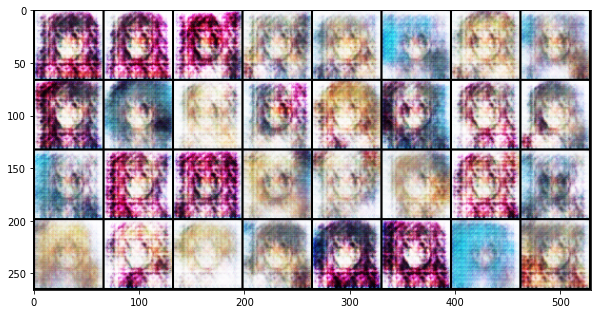

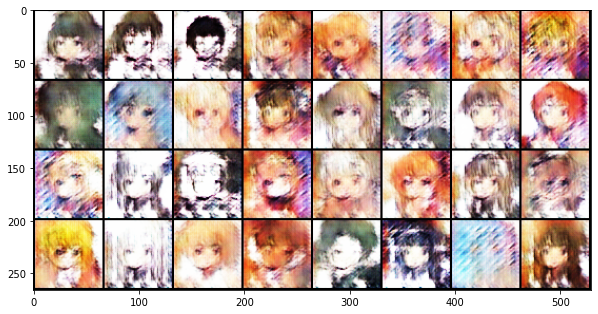

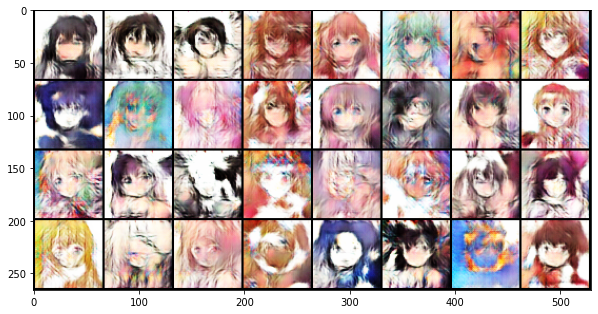

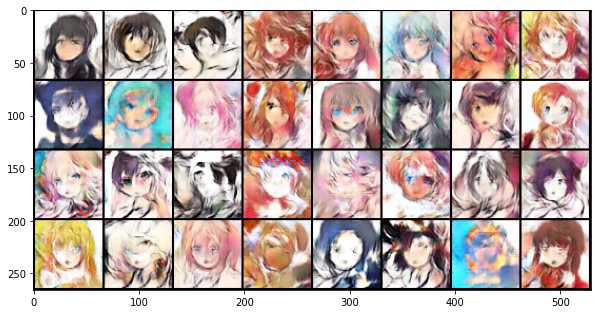

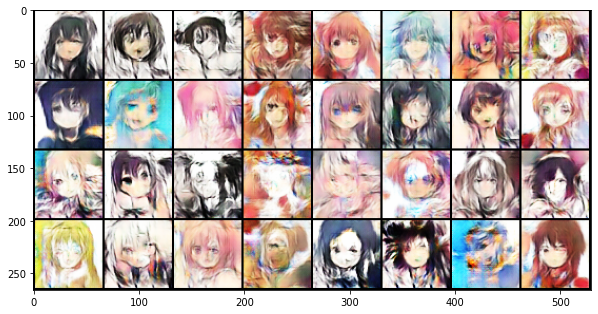

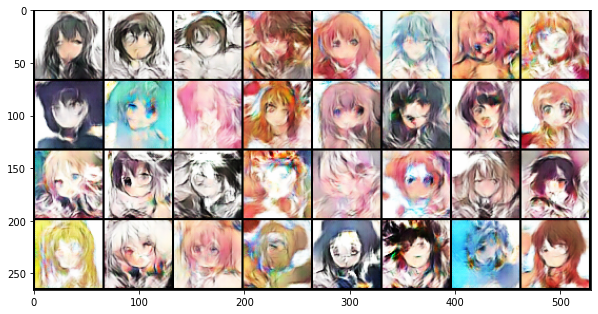

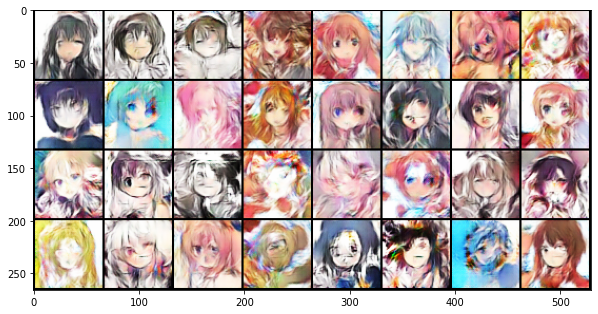

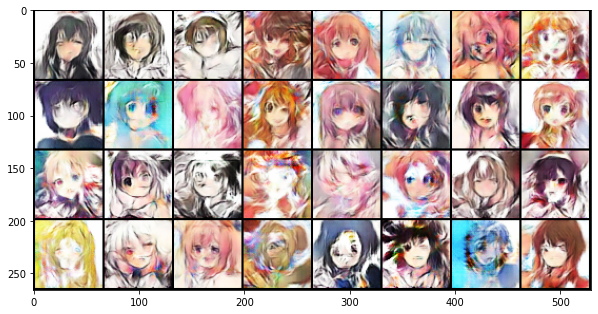

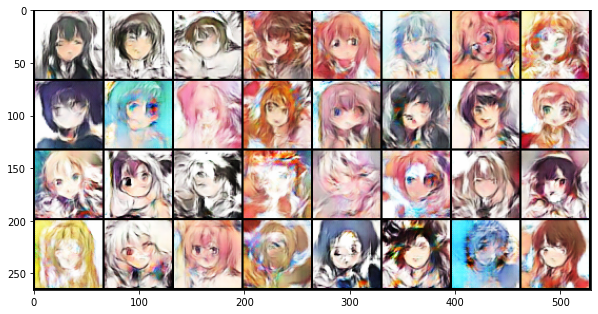

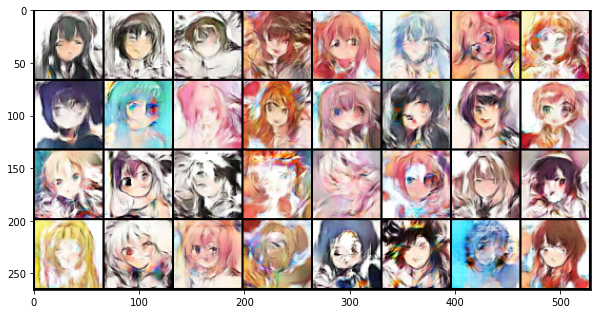

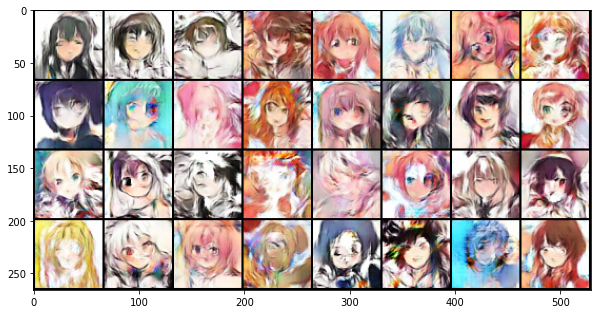

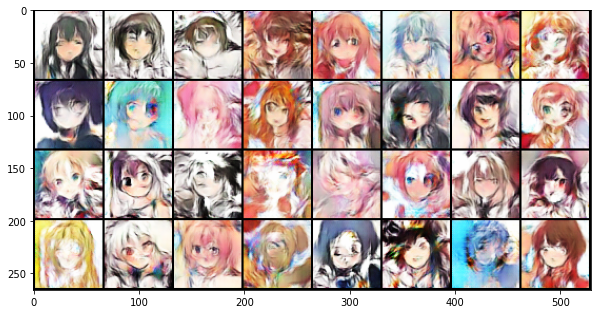

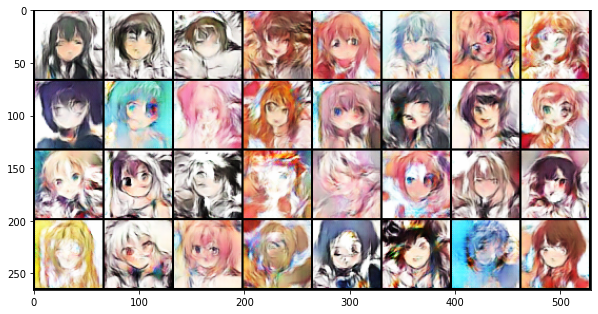

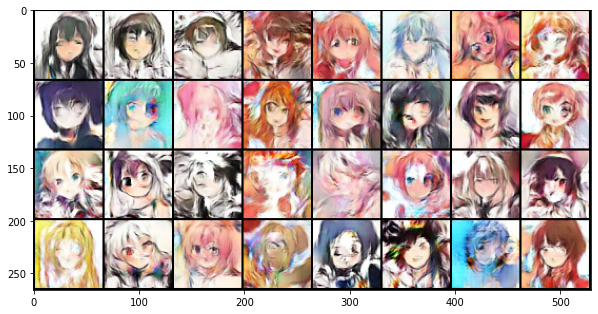

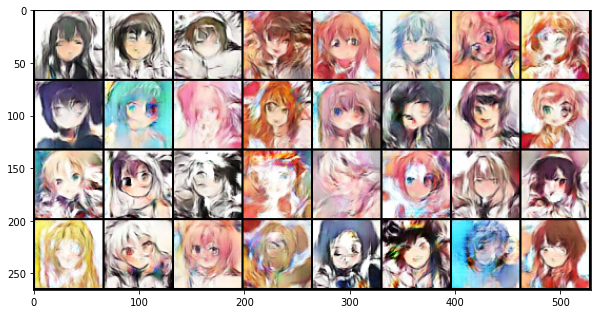

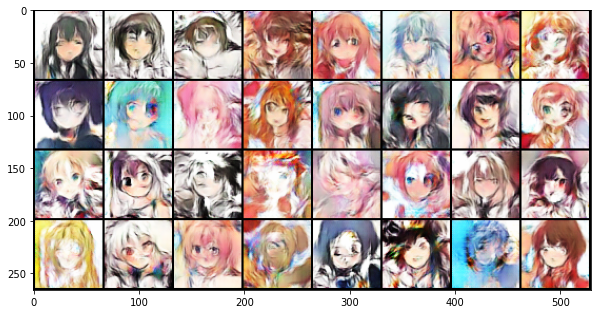

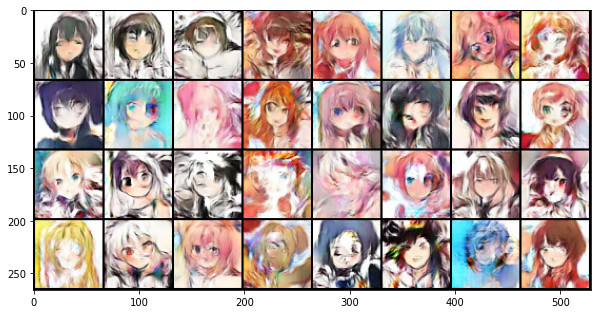

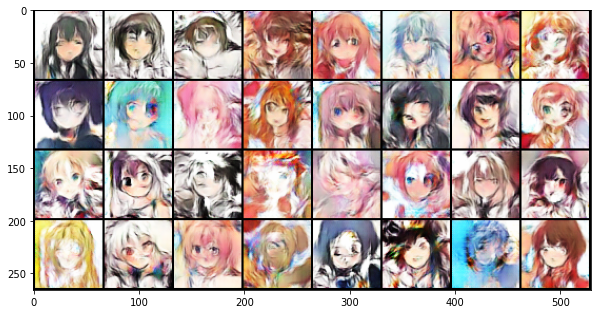

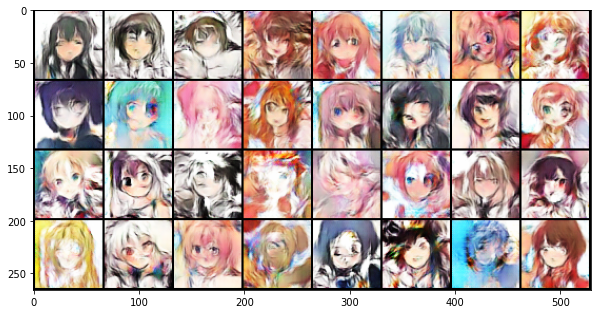

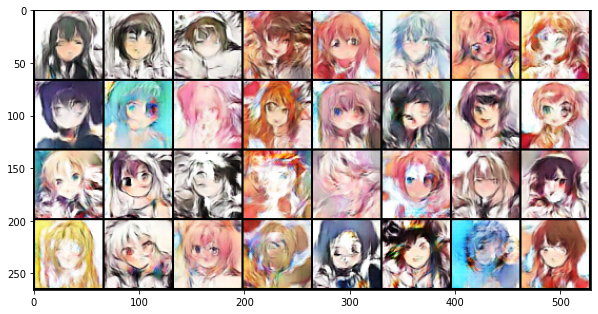

In [8]:
global_step = 0
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        
        dis_optimizer.zero_grad()

        # 真实数据
        real_img = data.to(device)
        bz = real_img.size(0)
        real_label = Uniform(0.9, 1.0).sample((bz,)).to(device)
#         real_label = torch.full((bz, ), real_idx, device=device, dtype=torch.float)
        
        # 生成数据
        noise = torch.randn(bz, nz, 1, 1, device=device)
        fake_img = gen(noise)
        fake_label = Uniform(0., 0.1).sample((bz,)).to(device)
#         fake_label = torch.full((bz, ), fake_idx, device=device, dtype=torch.float)
        
        # 训练判别器
        output_real = dis(real_img)
        d_real_loss = criterion(output_real.view(-1), real_label)
        d_real_loss.backward()
        output_fake = dis(fake_img.detach())
        d_fake_loss = criterion(output_fake.view(-1), fake_label)
        d_fake_loss.backward()
        
        d_loss = d_fake_loss + d_real_loss
        
        dis_optimizer.step()
        
#         d_x = output_real.mean().item()
#         d_g_z1 = output_fake.mean().item() 
        
        # 训练生成器
        gen_optimizer.zero_grad()
        real_label_g = real_label
        output_fake_g = dis(fake_img)
        g_loss = criterion(output_fake_g.view(-1), real_label_g)
        g_loss.backward()
        
        gen_optimizer.step()
        
#         g_x = output_fake.mean().item()
        
        # loss可视化
        writer.add_scalar('d_loss', d_loss, global_step)
        writer.add_scalar('g_loss', g_loss, global_step)
        global_step += 1
        
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'% (epoch, num_epochs, i, len(train_loader),
                     d_loss.item(), g_loss.item()))
            
        
    # 每过一个epoch更新一次lr
    lr_scheduler_d.step()
    lr_scheduler_g.step()
    
    # 显示生成图像质量
    with torch.no_grad():
        fake = gen(fixed_noise).detach().cpu()
    img_grid = make_grid(fake, padding=2, normalize=True)
    plt.figure(figsize=(10,10))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.show()
    
    
    # 保存模型
    if (epoch+1) % 10 == 0:
        checkpoint = {"g_model_state_dict": gen.state_dict(),
                      "d_model_state_dict": dis.state_dict(),
                      "epoch": epoch}
        path_checkpoint = os.path.join('./checkpoints', "checkpoint_{}_epoch.pkl".format(epoch))
        torch.save(checkpoint, path_checkpoint)